In [28]:
# Importing the necessary libraries
import os
import cv2
import keras
import itertools

import numpy as np 
import tensorflow as tf

from PIL import Image
from time import time
from glob import glob
from tqdm import tqdm
from google.colab import files
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Activation, Flatten

from matplotlib import pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Install the kaggle client for directly downloading the dataset to colab
!pip install -q kaggle
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"harismahmood","key":"07b1d1ffde3be9a09104a107276c9247"}'}

In [3]:
# Download the chest-xray-pneumonia-dataset to the colab environment
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d 'paultimothymooney/chest-xray-pneumonia'
!mkdir chest_xray_pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray_pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0442-

In [29]:
def show_image(path: list, dataset:str, label:str, num_pics=2):
  # Routine to plot the images
  if num_pics > 1:
    fig, ax = plt.subplots(1, num_pics, sharex=True)
    plt.tight_layout()
    ax = ax.ravel()
    for idx, pth in enumerate(path[:num_pics]):
      ax[idx].imshow(plt.imread(pth), cmap='gray')
    fig.suptitle('Dataset: {}, Label: {}'.format(dataset, label))
  elif num_pics == 1:
    plt.imshow(plt.imread(path[:num_pics][0]), cmap='gray')
    plt.title('Dataset: {}, Label: {}'.format(dataset, label))
    plt.figure()

def visualize_dataset_distribution(dataset: dict, x_label: str, y_label: str, title: str):
  # Routine to visualize the per class distribution of the dataset
  folders = list(dataset.keys())
  folders_vals = list(map(lambda x: len(dataset[x]), folders))
  folders_paths = ['_'.join(x.split("/")[-2:]) for x in folders]
  for idx, f in enumerate(folders_paths):
    print('{}: contains {} images'.format(folders_paths[idx], folders_vals[idx]))
  plt.bar(folders_paths, folders_vals, width = 0.5, color = 'blue', align = 'center', edgecolor = 'black')
  plt.xticks(rotation=70)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title("Distribution of images in the dataset")
  plt.show()

def plot_confusion_matrix_self(cm, classes, title, cmap):
  plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  plt.ylabel(ylabel = 'True label', labelpad = 25)
  plt.xlabel(xlabel = 'Predicted label', labelpad = 25)
  plt.show()

In [5]:
# Make separate handles for the paths of the train, test and validation sets
# You can write the path below by manually scrolling to the chest_xray_pneumonia/chest_xray folder in the files section of this page
# Right click the on chest_xray folder and select copy path to paste below
path = "/content/chest_xray_pneumonia/chest_xray"
train_NORMAL = os.path.join(path, 'train/NORMAL')
train_PNEUMONIA = os.path.join(path, 'train/PNEUMONIA')
test_NORMAL = os.path.join(path, 'test/NORMAL')
test_PNEUMONIA = os.path.join(path, 'test/PNEUMONIA')
val_NORMAL = os.path.join(path, 'val/NORMAL')
val_PNEUMONIA = os.path.join(path, 'val/PNEUMONIA')
train_NORMAL_DIR = [os.path.join(train_NORMAL, x) for x in os.listdir(train_NORMAL)]
train_PNEUMONIA_DIR = [os.path.join(train_PNEUMONIA, x) for x in os.listdir(train_PNEUMONIA)]
test_NORMAL_DIR = [os.path.join(test_NORMAL, x) for x in os.listdir(test_NORMAL)]
test_PNEUMONIA_DIR = [os.path.join(test_PNEUMONIA, x) for x in os.listdir(test_PNEUMONIA)]
val_NORMAL_DIR = [os.path.join(val_NORMAL, x) for x in os.listdir(val_NORMAL)]
val_PNEUMONIA_DIR = [os.path.join(val_PNEUMONIA, x) for x in os.listdir(val_PNEUMONIA)]
dataset = {
    "train_NORMAL":train_NORMAL_DIR,
    "train_PNEUMONIA":train_PNEUMONIA_DIR,
    "test_NORMAL":test_NORMAL_DIR,
    "test_PNEUMONIA":test_PNEUMONIA_DIR,
    "val_NORMAL":val_NORMAL_DIR,
    "val_PNEUMONIA":val_PNEUMONIA_DIR
    }

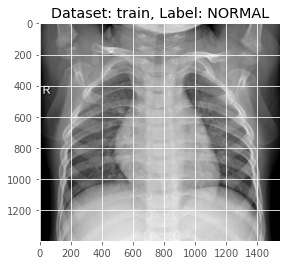

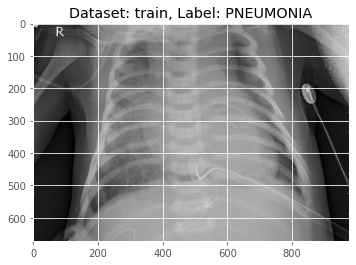

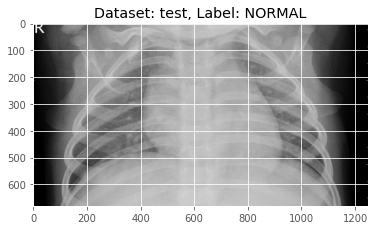

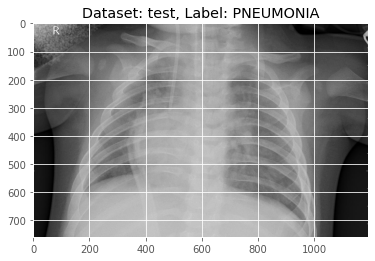

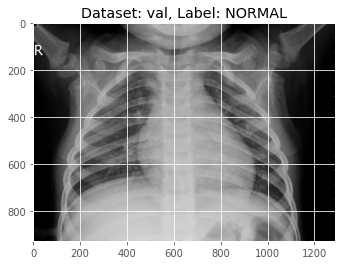

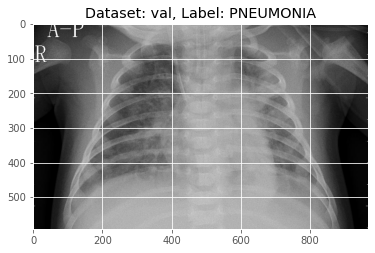

<Figure size 432x288 with 0 Axes>

In [6]:
# Visualizing the first num_pics image in the train, test and val datasets 
show_image(dataset["train_NORMAL"], num_pics=1, dataset="train", label="NORMAL")
show_image(dataset["train_PNEUMONIA"], num_pics=1, dataset="train", label="PNEUMONIA")

show_image(dataset["test_NORMAL"], num_pics=1, dataset="test", label="NORMAL")
show_image(dataset["test_PNEUMONIA"], num_pics=1, dataset="test", label="PNEUMONIA")

show_image(dataset["val_NORMAL"], num_pics=1, dataset="val", label="NORMAL")
show_image(dataset["val_PNEUMONIA"], num_pics=1, dataset="val", label="PNEUMONIA")

train_NORMAL: contains 1341 images
train_PNEUMONIA: contains 3875 images
test_NORMAL: contains 234 images
test_PNEUMONIA: contains 390 images
val_NORMAL: contains 8 images
val_PNEUMONIA: contains 8 images


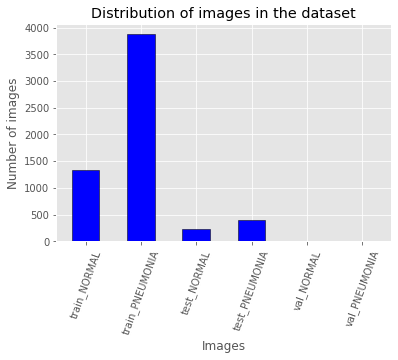

In [7]:
# Visualizing the datasets
x_label = "Images"
y_label = "Number of images"
title = "Distribution of images in the dataset"
visualize_dataset_distribution(dataset=dataset, x_label=x_label, y_label=y_label, title=title)

In [8]:
def transform_dataset(normal_path:str, pneumonia_path:str):
  # Routine to convert and return the X and y datasets as np.ndarrays after some preprocessing
  X, y = [], []
  for img in tqdm(glob(os.path.join(normal_path, "*.jpeg"))):
    img = cv2.imread(str(img))
    # Transform each stock image into a 224x224 RGB image and 
    # then into a vector of the same size but normalized between 0 and 1
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
      img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    X.append(img)

  initial = len(X)
  # Target labels -> 1 = Pneumonia, 0 = Normal
  y_a = np.zeros(initial)

  for img in tqdm(glob(os.path.join(pneumonia_path, "*.jpeg"))):
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
      img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    X.append(img)

  final = len(X)
  y = np.concatenate((y_a, np.ones(final-initial)))
  y = np.reshape(y, (y.shape[0],1))
  X = np.array(X)
  return X, y

In [9]:
# Generate the training sets
X_train, y_train = transform_dataset(normal_path=train_NORMAL, pneumonia_path=train_PNEUMONIA)
X_test, y_test = transform_dataset(normal_path=test_NORMAL, pneumonia_path=test_PNEUMONIA)
X_val, y_val = transform_dataset(normal_path=val_NORMAL, pneumonia_path=val_PNEUMONIA)

100%|██████████| 8/8 [00:00<00:00, 92.16it/s]


In [10]:
# Lets take a look at the shapes of our train matrices
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)
X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)
print("X_train has shape ", X_train.shape)
print("y_train has shape ", y_train.shape)
print("X_test has shape ", X_test.shape)
print("y_test has shape ", y_test.shape)
print("X_val has shape ", X_val.shape)
print("y_val has shape ", y_val.shape)

X_train has shape  (5216, 224, 224, 3)
y_train has shape  (5216, 1)
X_test has shape  (624, 224, 224, 3)
y_test has shape  (624, 1)
X_val has shape  (16, 224, 224, 3)
y_val has shape  (16, 1)


In [11]:
def model(input_shape:tuple=(224,224,3), classes=1, initializer=glorot_uniform):
  # Routine to define the model architecture here

  # Define the input to be a tensor of shape input_shape
  input = Input(input_shape)

  # First hidden layer
  X = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation = 'relu', kernel_initializer = initializer(seed=0))(input)
  X = Dropout(rate=0.2)(X)
  X = MaxPooling2D((2,2))(X)

  # Second hidden layer
  X = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation = 'relu', kernel_initializer = initializer(seed=0))(X)
  X = Dropout(rate=0.2)(X)
  X = MaxPooling2D((2,2))(X)

  # Third hidden layer
  X = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation = 'relu', kernel_initializer = initializer(seed=0))(X)
  X = Dropout(rate=0.2)(X)
  X = MaxPooling2D((2,2))(X)

  # Output layer
  X = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation = 'relu', kernel_initializer = initializer(seed=0))(X)
  X = Dropout(rate=0.2)(X)
  X = Flatten()(X)
  X = Dense(units=2048, activation='relu')(X)
  X = Dropout(rate=0.2)(X)
  X = Dense(units=1024, activation='relu')(X)
  X = Dropout(rate=0.2)(X)
  X = Dense(units=512, activation='relu')(X)
  X = Dropout(rate=0.2)(X)
  output = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)

  # Create model
  model = Model(inputs = input, outputs = output)
  return model

In [12]:
# Let's build the model and look at its summary
XNet = model(input_shape=(224,224,3), initializer=glorot_uniform)
XNet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0     

In [13]:
# Define the optimizer and other hyperparameters and metrics and compile the model
BATCH_SIZE = 32
EPOCHS = 10
checkpoint_filepath = "best_model"
optimizer = Adam(learning_rate=0.0001, decay=1e-5)
early_stopping = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor = 'val_accuracy', mode = "max", save_best_only=True, save_weights_only=True)
XNet.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [14]:
num_training_steps = X_train.shape[0]//BATCH_SIZE
num_validation_steps = len(X_val)
print("Number of training steps: ", num_training_steps)
print("Number of validation steps: ", num_validation_steps)

Number of training steps:  163
Number of validation steps:  16


In [15]:
# Fit the model and save the history
history = XNet.fit(
    x = X_train, 
    y = y_train, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    steps_per_epoch = num_training_steps,
    validation_data = (X_val, y_val),
    callbacks = [early_stopping, checkpoint]
    )

Epoch 1/10
163/163 [==============================] - 70s 226ms/step - loss: 0.2343 - accuracy: 0.9055 - val_loss: 0.3425 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 36s 223ms/step - loss: 0.1040 - accuracy: 0.9622 - val_loss: 0.3596 - val_accuracy: 0.7500
Epoch 3/10
163/163 [==============================] - 36s 222ms/step - loss: 0.0721 - accuracy: 0.9735 - val_loss: 0.2496 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 37s 225ms/step - loss: 0.0744 - accuracy: 0.9732 - val_loss: 0.3264 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 36s 223ms/step - loss: 0.0523 - accuracy: 0.9810 - val_loss: 0.3323 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 36s 223ms/step - loss: 0.0411 - accuracy: 0.9849 - val_loss: 0.2003 - val_accuracy: 0.8750
Epoch 7/10
163/163 [==============================] - 36s 223ms/step - loss: 0.0319 - accuracy: 0.9879 - val_loss: 0.1232 - val_ac

In [25]:
# Load the weights for the best performing model based on the set requirements
XNet.load_weights("best_model")

In [26]:
# Evaluation on the test set
test_loss, test_score = XNet.evaluate(
    X_test, 
    y_test, 
    batch_size=BATCH_SIZE)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

20/20 [==============================] - 1s 53ms/step - loss: 0.8369 - accuracy: 0.7692
Loss on test set:  0.8369212746620178
Accuracy on test set:  0.7692307829856873


In [23]:
def infer_on_the_fly(model):
  # Allow user to upload images for inference
  uploaded = files.upload()
  for file_name in uploaded.keys():
    path = '/content/' + file_name
    # Transform each stock image into a 224x224 RGB image and 
    # then into a vector of the same size but normalized between 0 and 1
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
      img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    X = np.expand_dims(img, axis=0)
    X = np.array(X)
    X = tf.convert_to_tensor(X)

    y = model.predict(X, batch_size = 32)
    if y[0]> 0.5:
      print(file_name + ' is pneumonia with {} probability'.format(y[0]))
      plt.imshow(img)
    else:
      print(file_name + 'is normal with {} probability'.format(y[0]))
      plt.imshow(img)

Saving person1_virus_13.jpeg to person1_virus_13 (1).jpeg
person1_virus_13.jpeg is pneumonia with [0.99807715] probability


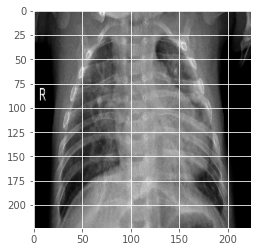

In [24]:
infer_on_the_fly(model=XNet)

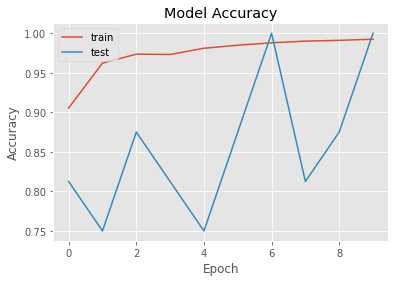

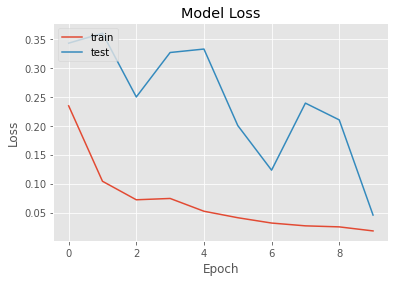

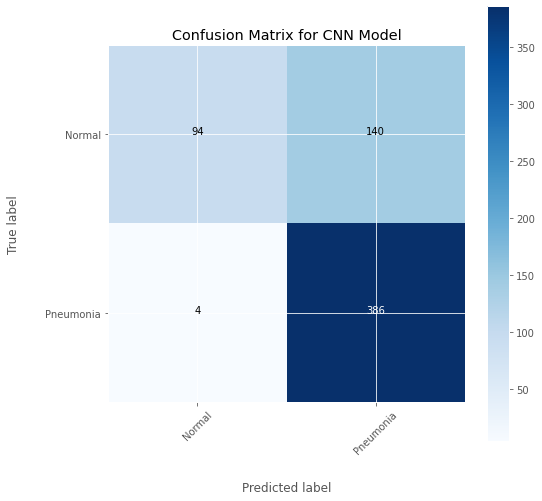

Recall of the model is 0.99
Precision of the model is 0.73


In [35]:
# Lets plot the model's history including the confusion matrix

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

y_pred = XNet.predict(X_test)
y_pred = (y_pred > 0.5)
cnf_matrix = confusion_matrix(y_test, y_pred, labels = [0. , 1.])
plot_confusion_matrix_self(cnf_matrix, classes = ["Normal" , "Pneumonia"], title = "Confusion Matrix for CNN Model", cmap = plt.cm.Blues)
plt.show()

# Calculate Precision and Recall
tn, fp, fn, tp = cnf_matrix.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))